[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/dsp_2025/blob/main/notebook_01.ipynb)

# Introducción al Procesamiento de Imágenes Digitales con Python

**Objetivo:** Este cuaderno introduce los conceptos fundamentales de las imágenes digitales y las técnicas básicas para su manipulación y análisis utilizando Python. Al finalizar, el estudiante será capaz de cargar, analizar, manipular y extraer información de imágenes digitales.

**Librerías utilizadas:**
*   `NumPy`: La librería fundamental para la computación científica en Python. La usaremos para manejar las imágenes como arreglos (matrices) numéricos.
*   `Matplotlib`: Para la visualización de datos y, en nuestro caso, para mostrar las imágenes y sus histogramas.
*   `OpenCV (cv2)`: Una librería de visión por computador muy potente, optimizada para operaciones de alto rendimiento.
*   `Scikit-image`: Otra librería de procesamiento de imágenes con un enfoque más educativo y algoritmos fáciles de usar.
*   `Pillow (PIL)`: Útil para tareas como la lectura de metadatos de las imágenes.


In [52]:
import cv2
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

from skimage.color import rgb2lab, rgb2hsv
from skimage.transform import resize

***

### **1. Lectura y Visualización de Imágenes**

Una imagen digital puede ser representada como una matriz. Para una imagen en escala de grises, es una matriz 2D donde cada elemento representa la intensidad de un píxel. Para una imagen a color, es una matriz 3D (alto x ancho x canales), donde el tercer eje corresponde a los canales de color.

El modelo de color más común es el **RGB** (Rojo, Verde, Azul). Sin embargo, es crucial saber que diferentes librerías pueden tratar los canales de color en un orden distinto.

*   `skimage.io.imread` y `matplotlib.pyplot.imshow` trabajan con el orden **RGB**.
*   `cv2.imread` trabaja con el orden **BGR** (Azul, Verde, Rojo).

Esto es una fuente común de errores. Si cargas una imagen con OpenCV y la muestras con Matplotlib sin corregir el orden de los canales, los colores se verán incorrectos.


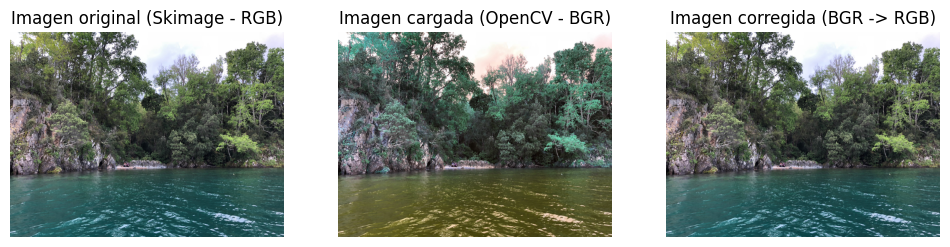

In [4]:
# Definimos la ruta de la imagen que vamos a utilizar
IMAGE_FILE = 'pucon.jpg' # Se recomienda tener la imagen en la misma carpeta

# --- Opción 1: Cargar con scikit-image (lee en RGB) ---
img_skimage = imread(IMAGE_FILE)

# --- Opción 2: Cargar con OpenCV (lee en BGR) ---
img_opencv = cv2.imread(IMAGE_FILE)

# --- Visualización ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Imagen original (Skimage - RGB)')
plt.imshow(img_skimage)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Imagen cargada (OpenCV - BGR)')
plt.imshow(img_opencv)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Imagen corregida (BGR -> RGB)')
# Corregimos el orden de los canales para una visualización correcta
img_opencv_rgb = cv2.cvtColor(img_opencv, cv2.COLOR_BGR2RGB)
plt.imshow(img_opencv_rgb)
plt.axis('off')

plt.show()

### **2. Propiedades Fundamentales de una Imagen**

#### **Resolución Espacial y Radiométrica**
*   **Resolución Espacial:** Se refiere al tamaño de la imagen en píxeles (ancho x alto). Reducir la resolución implica perder detalle.
*   **Resolución Radiométrica:** Es el número de bits utilizados para representar la intensidad de cada píxel. Una imagen de 8 bits puede tener 2⁸ = 256 niveles de intensidad por canal (de 0 a 255).


In [6]:
# Obtener y mostrar las propiedades de la imagen
height, width, channels = img_skimage.shape
print(f"Resolución Espacial: {width}x{height} píxeles")
print(f"Número de canales: {channels}")
print(f"Valor máximo de intensidad: {np.max(img_skimage)}")
print(f"Valor mínimo de intensidad: {np.min(img_skimage)}")

Resolución Espacial: 4032x3024 píxeles
Número de canales: 3
Valor máximo de intensidad: 255
Valor mínimo de intensidad: 0


#### **Modificar la Resolución Radiométrica**

Podemos simular una imagen con menos bits para entender el efecto de la cuantización. Al reducir los bits, se pierden tonalidades y pueden aparecer "bandas" o contornos falsos (posterización).


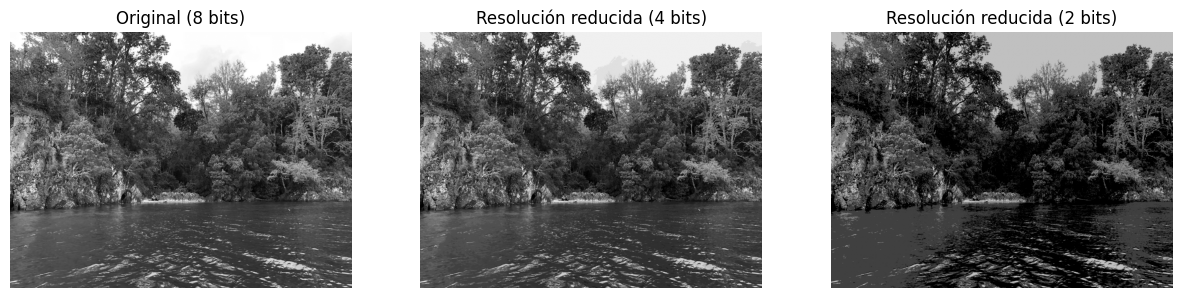

In [10]:
def reduce_bits(image, input_bits=8, target_bits=4):
    """
    Reduce la profundidad de bits de una imagen en escala de grises.
    """
    # Escalar los valores de píxeles al nuevo rango
    scaled_image = np.floor(image / (2**(input_bits - target_bits)))
    # Convertir a un tipo de dato que pueda manejar Matplotlib
    return scaled_image.astype(np.uint8)

# Convertir la imagen a escala de grises
img_gray = np.mean(img_skimage, axis=2).astype(np.uint8)

# Reducir a 4 bits (16 niveles de gris) y 2 bits (4 niveles)
reduced_image_4bit = reduce_bits(img_gray, target_bits=4)
reduced_image_2bit = reduce_bits(img_gray, target_bits=2)

# Visualizar la diferencia
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original (8 bits)')
plt.imshow(img_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Resolución reducida (4 bits)')
plt.imshow(reduced_image_4bit, cmap='gray', vmax=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Resolución reducida (2 bits)')
plt.imshow(reduced_image_2bit, cmap='gray', vmax=4)
plt.axis('off')

plt.show()

### **3. El Histograma de una Imagen**

El histograma es un gráfico que muestra la frecuencia de cada nivel de intensidad en una imagen. Es una herramienta fundamental para entender sus propiedades:
*   **Imágenes oscuras:** El histograma se concentra en la zona izquierda (valores bajos).
*   **Imágenes claras:** El histograma se concentra en la zona derecha (valores altos).
*   **Imágenes de bajo contraste:** El histograma ocupa un rango estrecho de valores.
*   **Imágenes bien contrastadas:** El histograma se distribuye por todo el rango de intensidades.


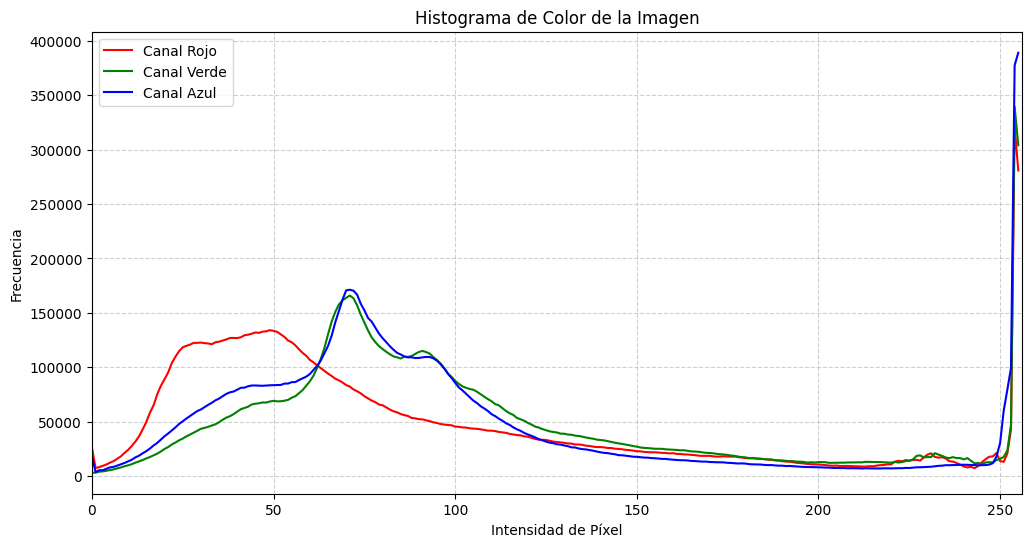

In [11]:
# Usaremos la imagen corregida de OpenCV
img_to_hist = cv2.cvtColor(img_opencv, cv2.COLOR_BGR2RGB)

# Definimos los colores para cada canal
colors = ('r', 'g', 'b')
channel_names = ('Canal Rojo', 'Canal Verde', 'Canal Azul')

plt.figure(figsize=(12, 6))
plt.title('Histograma de Color de la Imagen')
plt.xlabel('Intensidad de Píxel')
plt.ylabel('Frecuencia')

for i, color in enumerate(colors):
    # Calculamos el histograma para el canal i
    hist = cv2.calcHist([img_to_hist], [i], None, [256], [0, 256])
    plt.plot(hist, color=color, label=channel_names[i])

plt.xlim([0, 256])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### **4. Extracción de Metadatos EXIF**

Muchas imágenes digitales (especialmente de cámaras y smartphones) contienen metadatos **EXIF** (Exchangeable Image File Format). Estos datos incluyen información sobre la captura: modelo de la cámara, fecha, hora, e incluso coordenadas GPS. La librería Pillow es excelente para esta tarea.


In [48]:
def get_labeled_exif(filename):
    """
    Extrae y etiqueta los metadatos EXIF de una imagen.
    """
    try:
        image = Image.open(filename)
        image.verify()
        exif_data = image.getexif()
        if not exif_data:
            return "No se encontraron metadatos EXIF."
        labeled_exif = {}
        for (key, val) in exif.items():
            if TAGS.get(key) != 'MakerNote': # Avoid marker note of iphone
                labeled_exif[TAGS.get(key)] = val
        return labeled_exif
    except Exception as e:
        return f"Error al leer el archivo: {e}"

def get_gps_coordinates(exif):
    if not isinstance(exif, dict):
        raise ValueError("No EXIF metadata found")

    gps_info = exif.get("GPSInfo")
    if not gps_info:
        raise ValueError("No EXIF geotagging found")

    geotags = {}
    for key in gps_info:
        name = GPSTAGS.get(key)
        if name:
            geotags[name] = gps_info[key]

    dms_lat = geotags.get("GPSLatitude")
    dms_lon = geotags.get("GPSLongitude")
    ref_lat = geotags.get("GPSLatitudeRef")
    ref_lon = geotags.get("GPSLongitudeRef")

    if not all([dms_lat, dms_lon, ref_lat, ref_lon]):
        raise ValueError("Incomplete GPS data")

    lat = round(float(dms_lat[0]) + float(dms_lat[1]) / 60 + float(dms_lat[2]) / 3600, 5)
    lon = round(float(dms_lon[0]) + float(dms_lon[1]) / 60 + float(dms_lon[2]) / 3600, 5)

    print(lat, lon)

    if ref_lat in ["S"]: lat = -lat
    if ref_lon in ["W"]: lon = -lon

    return lat, lon

# Extraer y mostrar algunos metadatos importantes
metadata = get_labeled_exif(IMAGE_FILE)
lat, lon = get_gps_coordinates(metadata)

if isinstance(metadata, dict):
    print("Algunos metadatos encontrados:")
    print(f"  - Modelo de Cámara: {metadata.get('Model', 'No disponible')}")
    print(f"  - Fecha y Hora: {metadata.get('DateTime', 'No disponible')}")
    print(f"  - Latitud: {lat}, Longitud: {lon}")
else:
    print(metadata)


39.49911 72.15042
Algunos metadatos encontrados:
  - Modelo de Cámara: iPhone 8
  - Fecha y Hora: 2018:11:03 18:25:26
  - Latitud: -39.49911, Longitud: -72.15042


### **5. Espacios de Color**

Aunque el RGB es el más común, existen otros espacios de color que son más útiles para ciertas tareas de visión artificial porque separan la información de color de la de iluminación [1].
*   **HSV (Hue, Saturation, Value):** Descompone la imagen en Tono (el color en sí), Saturación (la pureza del color) y Valor (el brillo). Es muy intuitivo para la detección de colores.
*   **CIELab (o L\*a\*b\*):** Es un espacio de color perceptualmente uniforme. Esto significa que la distancia entre dos colores en este espacio se corresponde mejor con la diferencia de color que percibe el ojo humano.


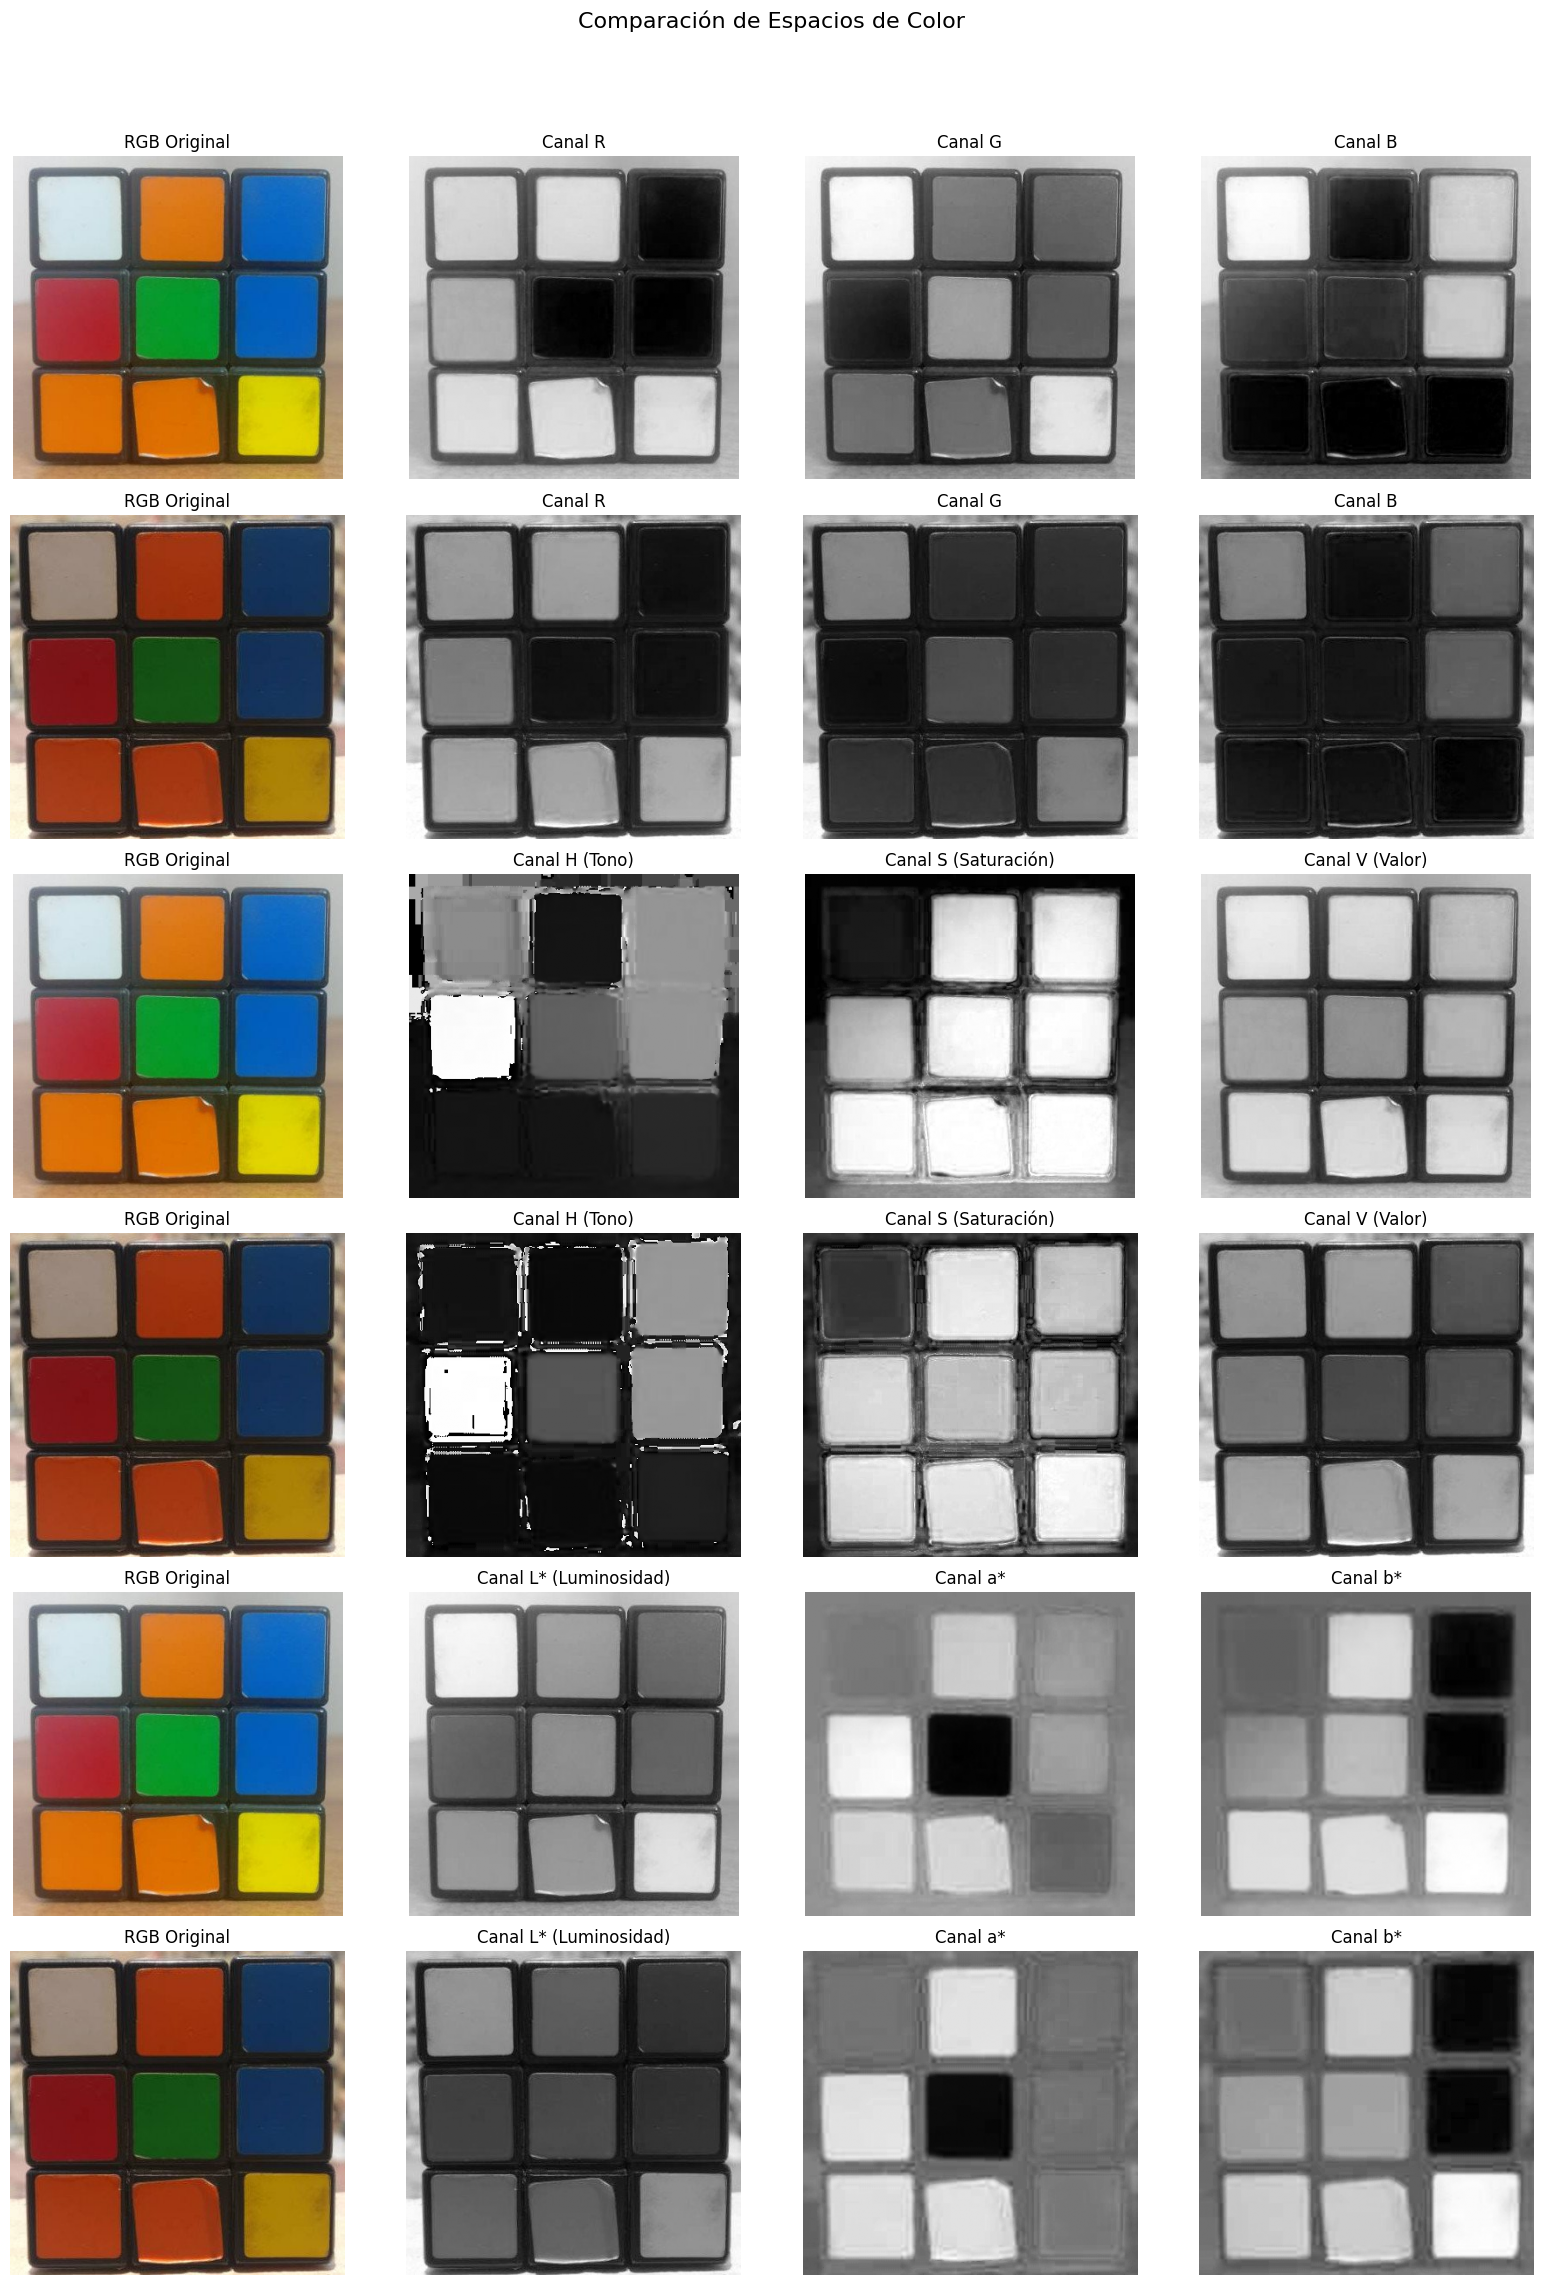

In [62]:
# Cargar una imagen para la demostración
img_color_1 = imread('rub07.jpg') # Asegúrate de tener esta imagen
img_color_2 = imread('rub09.jpg') # Asegúrate de tener esta imagen

# Convertir a HSV y CIELab
img_hsv_1 = rgb2hsv(img_color_1)
img_lab_1 = rgb2lab(img_color_1)

img_hsv_2 = rgb2hsv(img_color_2)
img_lab_2 = rgb2lab(img_color_2)

# --- Visualización de los canales de cada espacio de color ---

fig, axes = plt.subplots(6, 4, figsize=(16, 24))
fig.suptitle('Comparación de Espacios de Color', fontsize=16)

# Fila RGB
axes[0, 0].imshow(img_color_1)
axes[0, 0].set_title('RGB Original')
axes[0, 1].imshow(img_color_1[:, :, 0], cmap='gray')
axes[0, 1].set_title('Canal R')
axes[0, 2].imshow(img_color_1[:, :, 1], cmap='gray')
axes[0, 2].set_title('Canal G')
axes[0, 3].imshow(img_color_1[:, :, 2], cmap='gray')
axes[0, 3].set_title('Canal B')

axes[1, 0].imshow(img_color_2)
axes[1, 0].set_title('RGB Original')
axes[1, 1].imshow(img_color_2[:, :, 0], cmap='gray')
axes[1, 1].set_title('Canal R')
axes[1, 2].imshow(img_color_2[:, :, 1], cmap='gray')
axes[1, 2].set_title('Canal G')
axes[1, 3].imshow(img_color_2[:, :, 2], cmap='gray')
axes[1, 3].set_title('Canal B')

# Fila HSV
axes[2, 0].imshow(img_color_1)
axes[2, 0].set_title('RGB Original')
axes[2, 1].imshow(img_hsv_1[:, :, 0], cmap='gray')
axes[2, 1].set_title('Canal H (Tono)')
axes[2, 2].imshow(img_hsv_1[:, :, 1], cmap='gray')
axes[2, 2].set_title('Canal S (Saturación)')
axes[2, 3].imshow(img_hsv_1[:, :, 2], cmap='gray')
axes[2, 3].set_title('Canal V (Valor)')

axes[3, 0].imshow(img_color_2)
axes[3, 0].set_title('RGB Original')
axes[3, 1].imshow(img_hsv_2[:, :, 0], cmap='gray')
axes[3, 1].set_title('Canal H (Tono)')
axes[3, 2].imshow(img_hsv_2[:, :, 1], cmap='gray')
axes[3, 2].set_title('Canal S (Saturación)')
axes[3, 3].imshow(img_hsv_2[:, :, 2], cmap='gray')
axes[3, 3].set_title('Canal V (Valor)')

# Fila CIELab
axes[4, 0].imshow(img_color_1)
axes[4, 0].set_title('RGB Original')
axes[4, 1].imshow(img_lab_1[:, :, 0], cmap='gray')
axes[4, 1].set_title('Canal L* (Luminosidad)')
axes[4, 2].imshow(img_lab_1[:, :, 1], cmap='gray')
axes[4, 2].set_title('Canal a*')
axes[4, 3].imshow(img_lab_1[:, :, 2], cmap='gray')
axes[4, 3].set_title('Canal b*')

axes[5, 0].imshow(img_color_2)
axes[5, 0].set_title('RGB Original')
axes[5, 1].imshow(img_lab_2[:, :, 0], cmap='gray')
axes[5, 1].set_title('Canal L* (Luminosidad)')
axes[5, 2].imshow(img_lab_2[:, :, 1], cmap='gray')
axes[5, 2].set_title('Canal a*')
axes[5, 3].imshow(img_lab_2[:, :, 2], cmap='gray')
axes[5, 3].set_title('Canal b*')


for ax in axes.flat:
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

***
### **6. Ejercicios Propuestos**

1.  Busca y descarga una imagen de tu elección.
2.  Cárgala en el notebook.
3.  Conviértela a escala de grises.
4.  Calcula y muestra su histograma.
5.  En una celda de texto, describe si la imagen es predominantemente oscura, clara o si tiene un buen contraste, justificando tu respuesta con la forma del histograma.
